### Checking the ordering and such for CAMB, PolSpice, anafast, and synfast.
Note that all the spectra here are actually l(l+1)Cl/2pi, since that is what CAMB outputs. Doesn't matter for the sake of this check.

In [15]:
import camb
from ispice import ispice
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [16]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67., ombh2=0.02, omch2=0.12, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, r=0)
pars.set_for_lmax(1500, lens_potential_accuracy=0);
pars.DoLensing = True
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars)

### Use CAMB cls and invent the EB and TB cls.

In [17]:
dl_camb = powers['lensed_scalar'].swapaxes(0,1) #TT EE BB TE (CAMB order)
invent_eb_tb = np.array([dl_camb[3,:]*1e-3,dl_camb[2,:]*1e-2])
dl = np.concatenate([dl_camb,invent_eb_tb])
ell = np.arange(dl[1,:].size)+2.

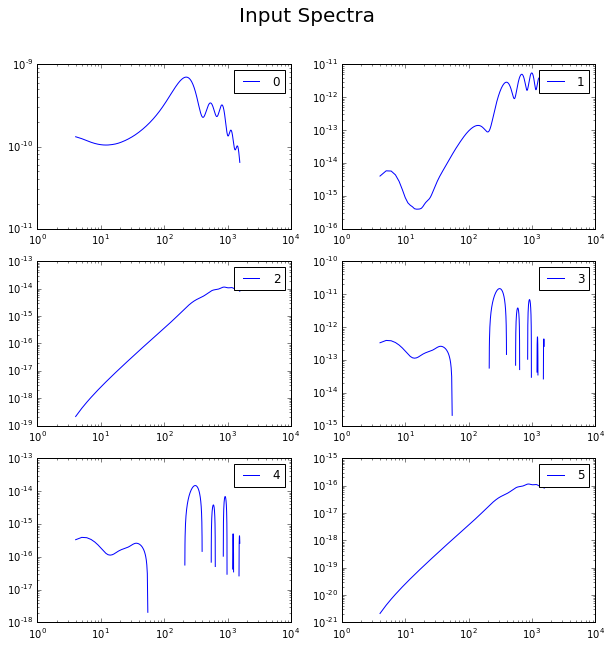

In [18]:
fig, axes = plt.subplots(3,2,figsize=(10,10))
fig.suptitle('Input Spectra',fontsize=20)
for i in range(6):
    ax = np.ravel(axes)[i]
    ax.loglog(ell,dl[i,:],label='%d'%i)
    ax.legend()

### Generate map with cls above, note that the ordering of the final two is different to polspice. 

In [19]:
cmb = hp.synfast(dl, 512, new = True, verbose = False) #TT, EE, BB, TE, and make up EB, TB

hp.write_map('polspice/map/example.fits', cmb)

cmb = hp.read_map('polspice/map/example.fits', field = (0, 1, 2), verbose = False)

### Do Polspice and anafast for comparison

Note that we are switching the PolSpice ordering of the last two elements to match the anafast / synfast convention.

In [20]:
ispice(mapin1="polspice/map/example.fits",
           clout="polspice/cls/example_cl.fits",
           polarization="YES",
           pixelfile="YES",
           )

hdu = fits.open('polspice/cls/example_cl.fits')
data_frame = pd.DataFrame(hdu[1].data)
data = fits.getdata('polspice/cls/example_cl.fits')
c_spice = np.zeros(6.*data.size).reshape((6,data.size))
for i,d in enumerate(data):   
    c_spice[0,i] = d[0]
    c_spice[1,i] = d[1]
    c_spice[2,i] = d[2]
    c_spice[3,i] = d[3]
    c_spice[4,i] = d[5]
    c_spice[5,i] = d[4]

ana_cls = hp.anafast(cmb)

Submitting job 0
../../DPhil/Codes/PolSpice/src/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile polspice/cls/example_cl.fits -decouple NO -mapfile polspice/map/example.fits -fits_out YES -nlmax -1 -normfac 1.00000 -npairsthreshold 0.00000 -overwrite YES -polarization YES -pixelfile YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 


/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Plot the spectra for polspice and anafast.
Note that the polspice and healpy conventions switch the order of TB and EB.  

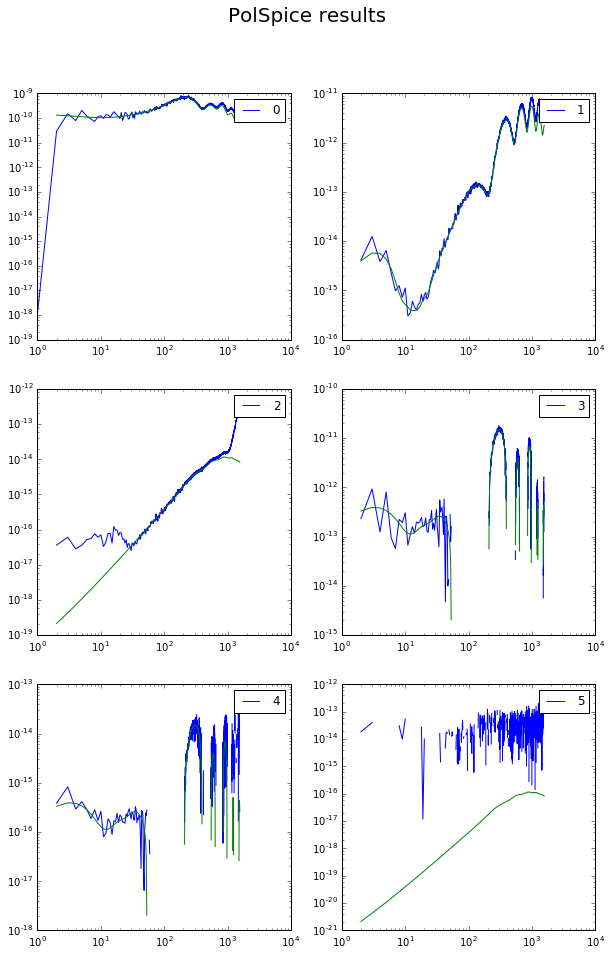

In [21]:
fig, axes = plt.subplots(3,2,figsize=(10,15))
fig.suptitle('PolSpice results',fontsize=20)
ell = np.arange(c_spice[0].size)
ell_d = np.arange(dl[0].size)
for j,(a,d) in enumerate(zip(c_spice,dl)):
    ax = np.ravel(axes)[j]
    ax.loglog(a,label='%d'%j)
    ax.loglog(d)
    ax.legend()

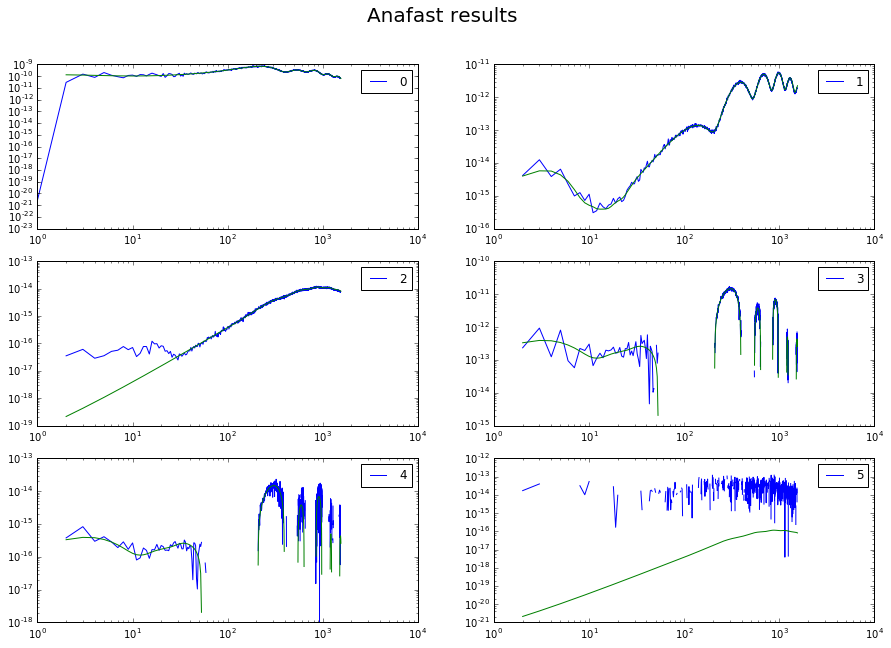

In [22]:
fig, axes = plt.subplots(3,2,figsize=(15,10))
fig.suptitle('Anafast results',fontsize=20)
for j,(a,d) in enumerate(zip(ana_cls,dl)):
    ax = np.ravel(axes)[j]
    ax.loglog(a,label='%d'%j)
    ax.loglog(d)
    ax.legend()